In [4]:
import notebook_env
import importlib
importlib.reload(notebook_env)
from notebook_env import *

In [95]:
dirs = glob('results/*CIFAR*16-False-*160*Backprop*')
dirs = sorted(dirs, key = lambda x : os.stat(x).st_mtime)[:]
results = { name: torch.load(name) for name in dirs }
dirs

['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-8-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-12-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-8-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl',
 

In [96]:
df = pd.DataFrame(columns=["scheme", "time_d","final_time_d","nsteps","accuracy","time/epoch (S)"])
for name, result in results.items():
    args = PostPack(name)
    if len(result.test_acc) < 159:
        acc = "NaN"
    else:
        acc = max(list(zip(*result.test_acc))[1])
    df.loc[len(df)] = \
        [args.scheme, args.initial_time_d, args.final_time_d,
                    args.n_steps_per, acc, result.epoch_times[-1]]
df.sort_values('time_d').sort_values('scheme')


,scheme,time_d,final_time_d,nsteps,accuracy,time/epoch (S)
8,euler,2,2,1,0.9083,11.253361
10,euler,2,8,1,0.9134,25.283692
11,euler,2,8,1,0.9162,26.775984
12,euler,2,8,1,0.9109,26.158741
0,euler,4,4,1,0.9168,20.540058
1,euler,6,6,1,0.9136,27.161397
3,euler,8,8,1,0.9138,35.873640
5,euler,12,12,1,0.9054,46.681769
9,rk4_classic,2,2,1,0.9144,25.133276
13,rk4_classic,2,8,1,0.9194,100.511385


In [78]:
refset,trainset,trainloader,testset,testloader = \
    datasets.get_dataset("CIFAR10",root='../data/')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [16]:
sdb = SimDataDB("results/manifestation_study.sqlite")

In [17]:
@sdb.Decorate(
    "fmnist",
    [("network","STRING"),("scheme","STRING"),("num_time","INT"),],
    [("train_acc","INT")])
@torch.no_grad()
def calc_acc_for_scheme_nt(name, scheme, nt):
    mod = results[name].model_list[-1]
    mod.eval()
    set_ode_config(mod, nt, scheme)
    return [refine_train.calculate_accuracy(mod, testloader)]

CREATE TABLE IF NOT EXISTS fmnist ( network STRING, scheme STRING, num_time INT, train_acc INT, timestamp VARCHAR(30), runtime FLOAT );


In [98]:
test_sweep = defaultdict( lambda : {} )
with torch.no_grad():
    for name, result in results.items():
        accs_for_scheme = {}
        for scheme in ('euler', 'midpoint','rk4'):
            accs = []
            for nt in progress( range(1, 16, 1), f"{legend_name(name)}, {scheme}"):
                accs.append((nt, calc_acc_for_scheme_nt(name, scheme, nt)[0]))
            accs_for_scheme[scheme] = accs
        test_sweep[name].update(accs_for_scheme)


-16-False-SkipInit-euler-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 15/15 [00:00<00:00, 1110.62it/s]

-16-False-SkipInit-euler-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 15/15 [00:00<00:00, 1065.50it/s]

-16-False-SkipInit-euler-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4: 100%|██████████| 15/15 [00:00<00:00, 1124.42it/s]

-16-False-SkipInit-euler-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 15/15 [00:00<00:00, 1137.94it/s]

-16-False-SkipInit-euler-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 15/15 [00:00<00:00, 1133.29it/s]

-16-False-SkipInit-euler-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4: 100%|██████████| 15/15 [00:00<00:00, 1117.92it/s]

-16-False-SkipInit-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Bac

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 1, 0.1125, datetime.datetime(2020, 5, 20, 17, 22, 21, 574591), 1.398329496383667]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  13%|█▎        | 2/15 [00:02<00:18,  1.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 2, 0.386, datetime.datetime(2020, 5, 20, 17, 22, 22, 981955), 1.3470520973205566]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  20%|██        | 3/15 [00:04<00:16,  1.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 3, 0.3159, datetime.datetime(2020, 5, 20, 17, 22, 24, 337656), 1.365534782409668]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  27%|██▋       | 4/15 [00:05<00:15,  1.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 4, 0.801, datetime.datetime(2020, 5, 20, 17, 22, 25, 711852), 1.3820245265960693]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  33%|███▎      | 5/15 [00:07<00:14,  1.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 5, 0.6555, datetime.datetime(2020, 5, 20, 17, 22, 27, 104335), 1.5646069049835205]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  40%|████      | 6/15 [00:08<00:13,  1.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 6, 0.7805, datetime.datetime(2020, 5, 20, 17, 22, 28, 677517), 1.7943367958068848]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  47%|████▋     | 7/15 [00:10<00:13,  1.69s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 7, 0.727, datetime.datetime(2020, 5, 20, 17, 22, 30, 480535), 1.994335651397705]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  53%|█████▎    | 8/15 [00:13<00:12,  1.84s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 8, 0.8797, datetime.datetime(2020, 5, 20, 17, 22, 32, 483379), 2.190438985824585]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  60%|██████    | 9/15 [00:15<00:12,  2.01s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 9, 0.8175, datetime.datetime(2020, 5, 20, 17, 22, 34, 682617), 2.4033515453338623]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  67%|██████▋   | 10/15 [00:18<00:11,  2.21s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 10, 0.8679, datetime.datetime(2020, 5, 20, 17, 22, 37, 94604), 2.6684112548828125]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  73%|███████▎  | 11/15 [00:21<00:09,  2.42s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 11, 0.8339, datetime.datetime(2020, 5, 20, 17, 22, 39, 773590), 2.879640817642212]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  80%|████████  | 12/15 [00:24<00:07,  2.62s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 12, 0.8977, datetime.datetime(2020, 5, 20, 17, 22, 42, 663573), 3.0782957077026367]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  87%|████████▋ | 13/15 [00:27<00:05,  2.83s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 13, 0.8642, datetime.datetime(2020, 5, 20, 17, 22, 45, 752779), 3.3032491207122803]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  93%|█████████▎| 14/15 [00:31<00:03,  3.05s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 14, 0.8857, datetime.datetime(2020, 5, 20, 17, 22, 49, 64726), 3.556190252304077]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 15/15 [00:34<00:00,  2.32s/it]

-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   0%|          | 0/15 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 15, 0.8656, datetime.datetime(2020, 5, 20, 17, 22, 52, 629822), 3.697842597961426]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   7%|▋         | 1/15 [00:01<00:19,  1.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 1, 0.2874, datetime.datetime(2020, 5, 20, 17, 22, 56, 338784), 1.3674602508544922]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  13%|█▎        | 2/15 [00:02<00:17,  1.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 2, 0.708, datetime.datetime(2020, 5, 20, 17, 22, 57, 714774), 1.348405361175537]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  20%|██        | 3/15 [00:04<00:17,  1.45s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 3, 0.8102, datetime.datetime(2020, 5, 20, 17, 22, 59, 71842), 1.6276159286499023]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  27%|██▋       | 4/15 [00:06<00:17,  1.62s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 4, 0.8963, datetime.datetime(2020, 5, 20, 17, 23, 0, 708149), 2.0027732849121094]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  33%|███▎      | 5/15 [00:08<00:18,  1.85s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 5, 0.8319, datetime.datetime(2020, 5, 20, 17, 23, 2, 719702), 2.3741531372070312]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  40%|████      | 6/15 [00:11<00:19,  2.13s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 6, 0.8934, datetime.datetime(2020, 5, 20, 17, 23, 5, 102258), 2.7750084400177]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  47%|████▋     | 7/15 [00:14<00:19,  2.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 7, 0.8935, datetime.datetime(2020, 5, 20, 17, 23, 7, 885829), 3.144275188446045]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  53%|█████▎    | 8/15 [00:18<00:19,  2.76s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 8, 0.916, datetime.datetime(2020, 5, 20, 17, 23, 11, 38603), 3.5160329341888428]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  60%|██████    | 9/15 [00:22<00:18,  3.10s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 9, 0.8922, datetime.datetime(2020, 5, 20, 17, 23, 14, 563416), 3.873399257659912]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  67%|██████▋   | 10/15 [00:26<00:17,  3.45s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 10, 0.9105, datetime.datetime(2020, 5, 20, 17, 23, 18, 445442), 4.255439281463623]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  73%|███████▎  | 11/15 [00:31<00:15,  3.81s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 11, 0.9061, datetime.datetime(2020, 5, 20, 17, 23, 22, 709819), 4.638627052307129]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  80%|████████  | 12/15 [00:36<00:12,  4.17s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 12, 0.9157, datetime.datetime(2020, 5, 20, 17, 23, 27, 357263), 5.007646560668945]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  87%|████████▋ | 13/15 [00:41<00:09,  4.53s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 13, 0.9006, datetime.datetime(2020, 5, 20, 17, 23, 32, 373471), 5.374471664428711]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  93%|█████████▎| 14/15 [00:47<00:04,  4.89s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 14, 0.915, datetime.datetime(2020, 5, 20, 17, 23, 37, 757973), 5.721030950546265]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 15/15 [00:53<00:00,  3.55s/it]

-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   0%|          | 0/15 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 15, 0.9105, datetime.datetime(2020, 5, 20, 17, 23, 43, 487865), 6.087587833404541]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   7%|▋         | 1/15 [00:01<00:18,  1.35s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 1, 0.5593, datetime.datetime(2020, 5, 20, 17, 23, 49, 586877), 1.3388211727142334]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  13%|█▎        | 2/15 [00:03<00:20,  1.54s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 2, 0.8904, datetime.datetime(2020, 5, 20, 17, 23, 50, 934048), 1.9918780326843262]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  20%|██        | 3/15 [00:06<00:23,  1.92s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 3, 0.911, datetime.datetime(2020, 5, 20, 17, 23, 52, 934721), 2.7813055515289307]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  27%|██▋       | 4/15 [00:09<00:26,  2.42s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 4, 0.9151, datetime.datetime(2020, 5, 20, 17, 23, 55, 725283), 3.5701496601104736]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  33%|███▎      | 5/15 [00:14<00:29,  2.98s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 5, 0.911, datetime.datetime(2020, 5, 20, 17, 23, 59, 304243), 4.2850868701934814]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  40%|████      | 6/15 [00:19<00:32,  3.60s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 6, 0.9117, datetime.datetime(2020, 5, 20, 17, 24, 3, 597950), 5.042102813720703]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  47%|████▋     | 7/15 [00:24<00:34,  4.26s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 7, 0.9172, datetime.datetime(2020, 5, 20, 17, 24, 8, 648977), 5.797713041305542]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  53%|█████▎    | 8/15 [00:31<00:34,  4.95s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 8, 0.9178, datetime.datetime(2020, 5, 20, 17, 24, 14, 455404), 6.548341989517212]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  60%|██████    | 9/15 [00:38<00:33,  5.66s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 9, 0.9153, datetime.datetime(2020, 5, 20, 17, 24, 21, 12509), 7.318440675735474]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  67%|██████▋   | 10/15 [00:46<00:31,  6.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 10, 0.9147, datetime.datetime(2020, 5, 20, 17, 24, 28, 339503), 8.064920902252197]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  73%|███████▎  | 11/15 [00:55<00:28,  7.10s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 11, 0.9161, datetime.datetime(2020, 5, 20, 17, 24, 36, 412917), 8.76144027709961]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  80%|████████  | 12/15 [01:05<00:23,  7.84s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 12, 0.9172, datetime.datetime(2020, 5, 20, 17, 24, 45, 183692), 9.540361881256104]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  87%|████████▋ | 13/15 [01:15<00:17,  8.59s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 13, 0.9165, datetime.datetime(2020, 5, 20, 17, 24, 54, 732662), 10.335814476013184]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  93%|█████████▎| 14/15 [01:26<00:09,  9.33s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 14, 0.9157, datetime.datetime(2020, 5, 20, 17, 25, 5, 79158), 11.050231218338013]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4: 100%|██████████| 15/15 [01:38<00:00,  6.56s/it]

-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   0%|          | 0/15 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 15, 0.9167, datetime.datetime(2020, 5, 20, 17, 25, 16, 140075), 11.809067010879517]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   7%|▋         | 1/15 [00:01<00:19,  1.36s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 1, 0.1, datetime.datetime(2020, 5, 20, 17, 25, 27, 963976), 1.3488478660583496]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  13%|█▎        | 2/15 [00:02<00:17,  1.36s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 2, 0.7048, datetime.datetime(2020, 5, 20, 17, 25, 29, 323063), 1.362663984298706]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  20%|██        | 3/15 [00:04<00:16,  1.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 3, 0.6497, datetime.datetime(2020, 5, 20, 17, 25, 30, 696688), 1.381432056427002]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  27%|██▋       | 4/15 [00:05<00:15,  1.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 4, 0.8706, datetime.datetime(2020, 5, 20, 17, 25, 32, 88655), 1.388547658920288]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  33%|███▎      | 5/15 [00:07<00:14,  1.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 5, 0.8228, datetime.datetime(2020, 5, 20, 17, 25, 33, 487536), 1.5538182258605957]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  40%|████      | 6/15 [00:08<00:13,  1.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 6, 0.8893, datetime.datetime(2020, 5, 20, 17, 25, 35, 52123), 1.8079257011413574]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  47%|████▋     | 7/15 [00:10<00:13,  1.69s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 7, 0.8633, datetime.datetime(2020, 5, 20, 17, 25, 36, 871038), 1.9903028011322021]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  53%|█████▎    | 8/15 [00:13<00:12,  1.82s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 8, 0.901, datetime.datetime(2020, 5, 20, 17, 25, 38, 872353), 2.1317837238311768]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  60%|██████    | 9/15 [00:15<00:11,  1.99s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 9, 0.8847, datetime.datetime(2020, 5, 20, 17, 25, 41, 15389), 2.3599648475646973]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  67%|██████▋   | 10/15 [00:18<00:10,  2.18s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 10, 0.901, datetime.datetime(2020, 5, 20, 17, 25, 43, 385212), 2.6221442222595215]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  73%|███████▎  | 11/15 [00:20<00:09,  2.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 11, 0.8899, datetime.datetime(2020, 5, 20, 17, 25, 46, 16673), 2.8208227157592773]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  80%|████████  | 12/15 [00:23<00:07,  2.57s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 12, 0.9046, datetime.datetime(2020, 5, 20, 17, 25, 48, 845624), 3.014209747314453]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  87%|████████▋ | 13/15 [00:27<00:05,  2.79s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 13, 0.8981, datetime.datetime(2020, 5, 20, 17, 25, 51, 868757), 3.2872817516326904]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  93%|█████████▎| 14/15 [00:30<00:03,  3.01s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 14, 0.9064, datetime.datetime(2020, 5, 20, 17, 25, 55, 164519), 3.5166513919830322]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 15/15 [00:34<00:00,  2.30s/it]

-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   0%|          | 0/15 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 15, 0.8992, datetime.datetime(2020, 5, 20, 17, 25, 58, 691075), 3.733675718307495]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   7%|▋         | 1/15 [00:01<00:20,  1.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 1, 0.3676, datetime.datetime(2020, 5, 20, 17, 26, 2, 436069), 1.4366776943206787]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  13%|█▎        | 2/15 [00:02<00:18,  1.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 2, 0.861, datetime.datetime(2020, 5, 20, 17, 26, 3, 881235), 1.402024269104004]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  20%|██        | 3/15 [00:04<00:18,  1.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 3, 0.8637, datetime.datetime(2020, 5, 20, 17, 26, 5, 292986), 1.6795845031738281]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  27%|██▋       | 4/15 [00:06<00:18,  1.66s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 4, 0.9086, datetime.datetime(2020, 5, 20, 17, 26, 6, 981037), 1.9860858917236328]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  33%|███▎      | 5/15 [00:08<00:18,  1.85s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 5, 0.9047, datetime.datetime(2020, 5, 20, 17, 26, 8, 976024), 2.2930123805999756]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  40%|████      | 6/15 [00:11<00:18,  2.10s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 6, 0.9077, datetime.datetime(2020, 5, 20, 17, 26, 11, 277634), 2.6596100330352783]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  47%|████▋     | 7/15 [00:14<00:19,  2.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 7, 0.9061, datetime.datetime(2020, 5, 20, 17, 26, 13, 946065), 3.0251104831695557]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  53%|█████▎    | 8/15 [00:17<00:18,  2.69s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 8, 0.9106, datetime.datetime(2020, 5, 20, 17, 26, 16, 979945), 3.4198131561279297]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  60%|██████    | 9/15 [00:21<00:18,  3.01s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 9, 0.9091, datetime.datetime(2020, 5, 20, 17, 26, 20, 410263), 3.7525949478149414]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  67%|██████▋   | 10/15 [00:25<00:16,  3.35s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 10, 0.909, datetime.datetime(2020, 5, 20, 17, 26, 24, 171451), 4.14060640335083]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  73%|███████▎  | 11/15 [00:30<00:14,  3.69s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 11, 0.9095, datetime.datetime(2020, 5, 20, 17, 26, 28, 320597), 4.4607274532318115]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  80%|████████  | 12/15 [00:35<00:12,  4.20s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 12, 0.9111, datetime.datetime(2020, 5, 20, 17, 26, 32, 790063), 5.383480787277222]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  87%|████████▋ | 13/15 [00:41<00:09,  4.60s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 13, 0.9101, datetime.datetime(2020, 5, 20, 17, 26, 38, 184137), 5.522068500518799]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  93%|█████████▎| 14/15 [00:46<00:04,  4.88s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 14, 0.9097, datetime.datetime(2020, 5, 20, 17, 26, 43, 716293), 5.521159887313843]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 15/15 [00:52<00:00,  3.52s/it]

-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   0%|          | 0/15 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 15, 0.9118, datetime.datetime(2020, 5, 20, 17, 26, 49, 245885), 5.910409450531006]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   7%|▋         | 1/15 [00:01<00:19,  1.40s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 1, 0.8449, datetime.datetime(2020, 5, 20, 17, 26, 55, 167031), 1.3946123123168945]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  13%|█▎        | 2/15 [00:03<00:20,  1.57s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 2, 0.9068, datetime.datetime(2020, 5, 20, 17, 26, 56, 571028), 1.940040111541748]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  20%|██        | 3/15 [00:06<00:22,  1.91s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 3, 0.9097, datetime.datetime(2020, 5, 20, 17, 26, 58, 520398), 2.70652174949646]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  27%|██▋       | 4/15 [00:09<00:26,  2.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 4, 0.9108, datetime.datetime(2020, 5, 20, 17, 27, 1, 235715), 3.438356637954712]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  33%|███▎      | 5/15 [00:13<00:29,  2.91s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 5, 0.9099, datetime.datetime(2020, 5, 20, 17, 27, 4, 682723), 4.146501541137695]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  40%|████      | 6/15 [00:18<00:31,  3.53s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 6, 0.9113, datetime.datetime(2020, 5, 20, 17, 27, 8, 839382), 4.976682424545288]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  47%|████▋     | 7/15 [00:24<00:33,  4.19s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 7, 0.9112, datetime.datetime(2020, 5, 20, 17, 27, 13, 824706), 5.711477279663086]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  53%|█████▎    | 8/15 [00:30<00:34,  4.87s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 8, 0.9117, datetime.datetime(2020, 5, 20, 17, 27, 19, 546321), 6.458858251571655]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  60%|██████    | 9/15 [00:38<00:33,  5.57s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 9, 0.9111, datetime.datetime(2020, 5, 20, 17, 27, 26, 14070), 7.186717987060547]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  67%|██████▋   | 10/15 [00:45<00:31,  6.28s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 10, 0.9113, datetime.datetime(2020, 5, 20, 17, 27, 33, 209881), 7.940891981124878]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  73%|███████▎  | 11/15 [00:54<00:28,  7.01s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 11, 0.911, datetime.datetime(2020, 5, 20, 17, 27, 41, 159902), 8.707082033157349]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  80%|████████  | 12/15 [01:04<00:23,  7.74s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 12, 0.9111, datetime.datetime(2020, 5, 20, 17, 27, 49, 876019), 9.417586326599121]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  87%|████████▋ | 13/15 [01:14<00:16,  8.46s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 13, 0.9115, datetime.datetime(2020, 5, 20, 17, 27, 59, 302277), 10.142173290252686]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  93%|█████████▎| 14/15 [01:25<00:09,  9.21s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 14, 0.9116, datetime.datetime(2020, 5, 20, 17, 28, 9, 453226), 10.95573902130127]



-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4: 100%|██████████| 15/15 [01:36<00:00,  6.46s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 15, 0.9114, datetime.datetime(2020, 5, 20, 17, 28, 20, 419931), 11.640730619430542]


results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-8-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-12-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-8-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-Single

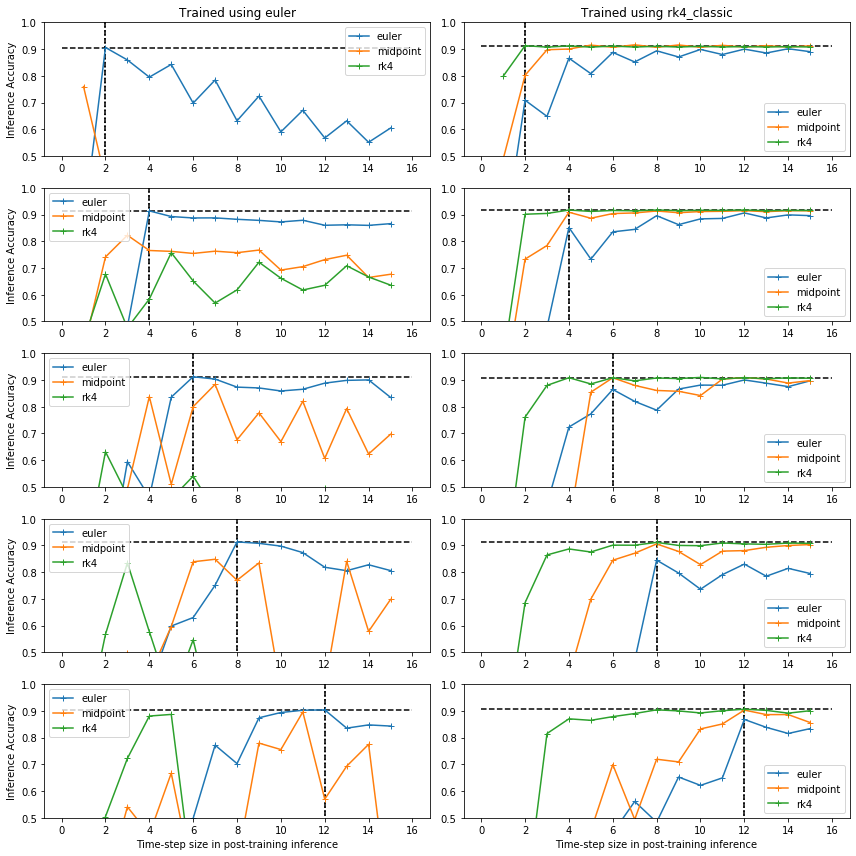

In [100]:
plt.figure(figsize=(12,12))
cols = []
for name, accs_for_scheme in test_sweep.items():
    print(name)
    args = PostPack(name)
    if len(args.refine)>0: continue
    cols.append(args.final_time_d)
cols = { c:i for i,c in enumerate(sorted(set(cols))) }
print(cols)
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if len(args.refine)>0: continue
    col = cols[args.final_time_d]
    horz = (0 if args.scheme=="euler" else 1)
    plt.subplot(len(cols), 2, 2*col + 1 + horz)
    for scheme, accs in accs_for_scheme.items():
        x,y = zip(*accs)
        #if scheme in name:
        #    plt.semilogx(1.0/x[0],y[0],'o')
        # plt.vlines([3.0],0,1,linestyle='dotted')
        # plt.plot(x, y, label=scheme)
        if scheme in args.scheme:
            for i,nt in enumerate(x):
                if nt == args.final_time_d:
                    best_idx = i
                    break
            plt.hlines([y[best_idx]],0,16.0, linestyles='dashed')
        # plt.semilogx([1.0/_x for _x in x], y, '+-', label=scheme)
        plt.plot(x, y, '+-', label=scheme)

    #plt.vlines([1.0/8.0],0,1,linestyles='dotted')
    plt.vlines([args.initial_time_d],0,1,linestyles='dotted')
    plt.vlines([args.final_time_d],0,1,linestyles='dashed')
    plt.ylim(0.5,1.0)
    plt.legend()
    if col == max(cols.values()):
        plt.xlabel('Time-step size in post-training inference')
    if col == 0:
        plt.title("Trained using "+args.scheme)
    if horz == 0:
        plt.ylabel("Inference Accuracy")
plt.tight_layout()
plt.show()

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-8-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-12-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-8-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-Single

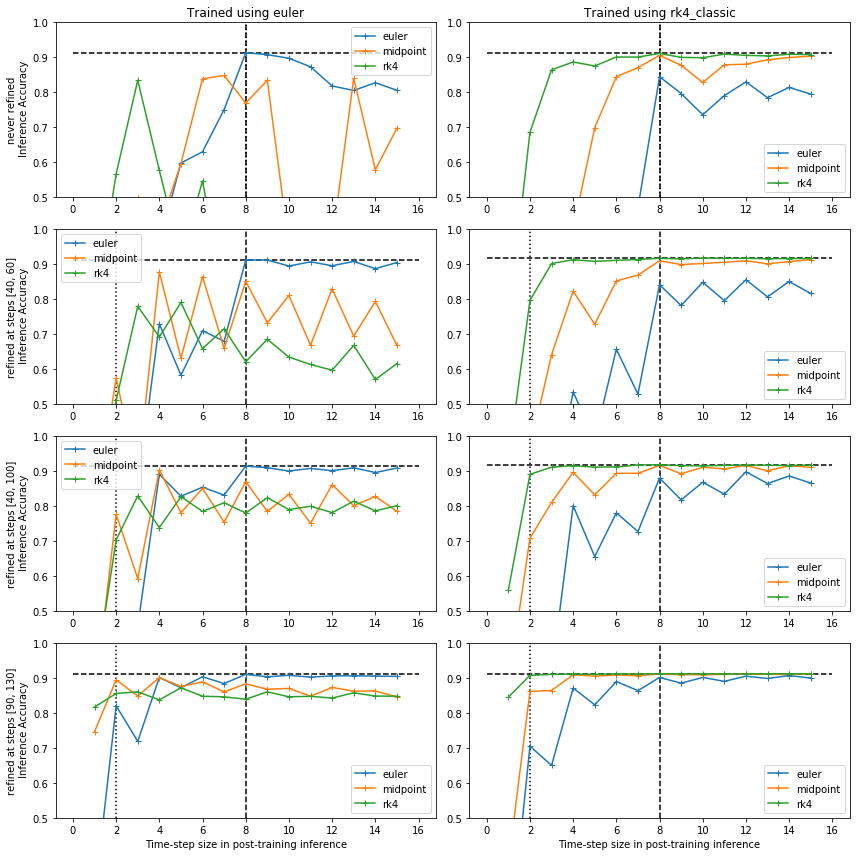

In [99]:
plt.figure(figsize=(12,12))
cols = []
for name, accs_for_scheme in test_sweep.items():
    print(name)
    args = PostPack(name)
    if args.final_time_d!=8: continue
    cols.append(args.refine[-1] if args.refine else 0)
cols = { c:i for i,c in enumerate(sorted(set(cols))) }
print(cols)
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if args.final_time_d!=8: continue
    col = cols[args.refine[-1] if args.refine else 0]
    horz = (0 if args.scheme=="euler" else 1)
    plt.subplot(len(cols), 2, 2*col + 1 + horz)
    for scheme, accs in accs_for_scheme.items():
        x,y = zip(*accs)
        #if scheme in name:
        #    plt.semilogx(1.0/x[0],y[0],'o')
        # plt.vlines([3.0],0,1,linestyle='dotted')
        # plt.plot(x, y, label=scheme)
        if scheme in args.scheme:
            for i,nt in enumerate(x):
                if nt == args.final_time_d:
                    best_idx = i
                    break
            plt.hlines([y[best_idx]],0,16.0, linestyles='dashed')
        # plt.semilogx([1.0/_x for _x in x], y, '+-', label=scheme)
        plt.plot(x, y, '+-', label=scheme)

    #plt.vlines([1.0/8.0],0,1,linestyles='dotted')
    plt.vlines([args.initial_time_d],0,1,linestyles='dotted')
    plt.vlines([args.final_time_d],0,1,linestyles='dashed')
    plt.ylim(0.5,1.0)
    plt.legend()
    if col == max(cols.values()):
        plt.xlabel('Time-step size in post-training inference')
    if col == 0:
        plt.title("Trained using "+args.scheme)
    if horz == 0:
        plt.ylabel((f"refined at steps {args.refine}" if args.refine else "never refined") + "\n Inference Accuracy" )
plt.tight_layout()
plt.show()